In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pylab as plt

c = 299792458. # m/s
np.random.seed(42)
sqrttwopi = np.sqrt(2. * np.pi)

# Borrowing code from EPRV to make fake data + template:

In [3]:
def doppler(rv):
    beta = rv / c
    return np.sqrt((1. - beta) / (1. + beta))

def oned_gaussian(xs, mm, sig):
    return np.exp(-0.5 * (xs - mm) ** 2 / sig ** 2) / (sqrttwopi * sig)

def make_synth(rv, xs, ds, ms, sigs):
    """
    Generate a noiseless synthetic spectrum at given rv shift.
    `rv`: radial velocity in m/s (or same units as `c` above)
    `xs`: `[M]` array of wavelength values
    `ds`: depths at line centers
    `ms`: locations of the line centers in rest wavelength
    `sigs`: Gaussian sigmas of lines
    --
    We take the view that lines multiply into the spectrum.
    """
    lnsynths = np.zeros_like(xs)
    for d, m, sig in zip(ds, ms, sigs):
        lnsynths += (d * oned_gaussian(xs * doppler(rv), m, sig))
    return np.exp(lnsynths)

def make_data(N, xs, ds, ms, sigs, snr):
    """
    Generate a set of N synthetic spectra.
    `N`: number of spectra to make
    `xs`: `[M]` array of wavelength values
    `ds`: depth-like parameters for lines
    `ms`: locations of the line centers in rest wavelength
    `sigs`: Gaussian sigmas of lines
    `snr`: desired SNR per pixel
    """
    M = len(xs)
    data = np.zeros((N, M))
    ivars = np.zeros((N, M))
    rvs = 30000. * np.random.uniform(-1., 1., size=N) # 30 km/s bc Earth ; MAGIC
    for n, rv in enumerate(rvs):
        ivars[n, :] = snr**2.
        data[n, :] = make_synth(rv, xs, ds, ms, sigs)
        data[n, :] += np.random.normal(size=M) / np.sqrt(ivars[n, :])
    return data, ivars, rvs

In [4]:
fwhms = np.asarray([0.1077, 0.1113, 0.1044, 0.1083, 0.1364, 0.1, 0.1281,
                    0.1212, 0.1292, 0.1526, 0.1575, 0.1879]) # FWHM of Gaussian fit to line (A)
sigs = fwhms / 2. / np.sqrt(2. * np.log(2.)) # Gaussian sigma (A)
ms = np.asarray([4997.967, 4998.228, 4998.543, 4999.116, 4999.508, 5000.206, 5000.348,
                5000.734, 5000.991, 5001.229, 5001.483, 5001.87]) # line center (A)
cs = np.asarray([-0.113524, -0.533461, -0.030569, -0.351709, -0.792123, -0.234712, -0.610711,
                -0.123613, -0.421898, -0.072386, -0.147218, -0.757536]) # contrast (normalized flux)
ds = np.log(1. + cs) * sigs * sqrttwopi # trust us
dx = 0.01 # A
xs = np.arange(4998. + 0.5 * dx, 5002., dx) # A
snr = 100.

N = 64
data, ivars, true_rvs = make_data(N, xs, ds, ms, sigs, snr)

In [5]:
data_xs = np.tile(xs, (N,1))


In [6]:
template_xs = np.arange(4997. + 0.5 * dx, 5003., dx) # A
template = make_synth(0.0, template_xs, ds, ms, sigs)
template += np.random.normal(size=len(template_xs)) / 500. # SNR = 500

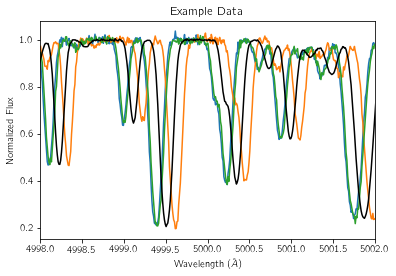

In [7]:
for n in range(0,N,30):
    plt.plot(data_xs[n], data[n])
plt.plot(template_xs, template, color='k')
plt.xlim([4998.,5002.])
plt.title('Example Data')
plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel(r'Normalized Flux')

# now solve for RVs with tensorflow:

In [8]:
%%time
from wobble.interp import interp
import tensorflow as tf
T = tf.float64

/Users/dforeman/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


CPU times: user 1.26 s, sys: 325 ms, total: 1.58 s
Wall time: 1.66 s


In [9]:
def doppler(v):
    frac = (1. - v/c) / (1. + v/c)
    return tf.sqrt(frac)

In [10]:
%%time
model_xs_tensor = tf.constant(np.log(template_xs), dtype=T)
model_ys_tensor = tf.Variable(np.log(template), dtype=T)
data_tensor = tf.constant(np.log(data), dtype=T)
xs_tensor = tf.constant(np.log(data_xs), dtype=T)
ivars_tensor = tf.constant(ivars, dtype=T)

CPU times: user 6.3 ms, sys: 2.36 ms, total: 8.66 ms
Wall time: 7.19 ms


In [11]:
%%time
starting_rvs = true_rvs + np.random.normal(0., 100., len(true_rvs))
rvs_tensor = tf.Variable(starting_rvs, dtype=T)

CPU times: user 3.92 ms, sys: 552 µs, total: 4.48 ms
Wall time: 3.98 ms


In [12]:
%%time
shifted_xs = xs_tensor + tf.log(doppler(rvs_tensor[:, None]))
models = interp(shifted_xs, model_xs_tensor, model_ys_tensor)
nll = 0.5*tf.reduce_sum(tf.square(data_tensor - models) * ivars_tensor)

CPU times: user 43.7 ms, sys: 2.27 ms, total: 46 ms
Wall time: 45.1 ms


In [13]:
%%time
grad_model = tf.gradients(nll, [model_ys_tensor])[0] + tf.zeros_like(model_ys_tensor)
grad_rvs = tf.gradients(nll, [rvs_tensor])[0] + tf.zeros_like(rvs_tensor)

CPU times: user 246 ms, sys: 8.79 ms, total: 254 ms
Wall time: 255 ms


In [14]:
%%time
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    models_eval = session.run(models)

CPU times: user 47 ms, sys: 5.46 ms, total: 52.4 ms
Wall time: 49.3 ms


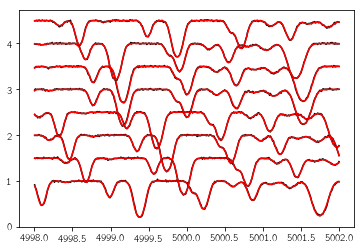

In [15]:
for n in range(8):
    offset = 0.5 * n
    plt.plot(data_xs[n], offset + data[n], color='k')
    plt.plot(data_xs[n], offset + np.exp(models_eval[n]), color='r')

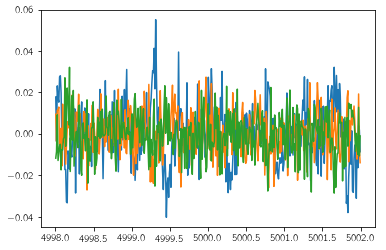

In [16]:
for n in range(0,N,30):
    plt.plot(data_xs[n], data[n] - np.exp(models_eval[n]))

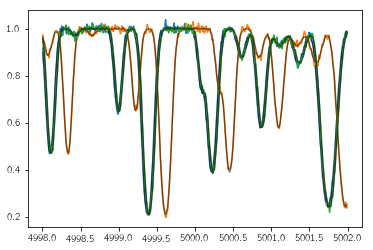

In [17]:
for n in range(0,N,30):
    plt.plot(data_xs[n], data[n])
    plt.plot(data_xs[n], np.exp(models_eval[n]), color='k', alpha=0.5)

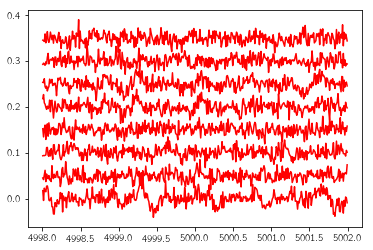

In [18]:
for n in range(8):
    offset = 0.05 * n
    plt.plot(data_xs[n], offset + data[n]- np.exp(models_eval[n]), color='r')

In [19]:
%%time
opt_rvs = tf.train.AdagradOptimizer(100.).minimize(nll, var_list=rvs_tensor)

CPU times: user 118 ms, sys: 5.46 ms, total: 123 ms
Wall time: 122 ms


In [20]:
%%time
session = tf.Session()
session.run(tf.global_variables_initializer())

CPU times: user 38.1 ms, sys: 4.83 ms, total: 43 ms
Wall time: 41.2 ms


In [21]:
session.run(grad_rvs)

array([-5.8254041 ,  1.37777203, -1.69447813, -0.3533562 ,  3.04899412,
        4.31946423, -1.67195747,  1.62219448, -1.03188649, -0.35450902,
       -1.18803924, -2.93847907,  0.82662248,  0.66560039, -1.41088039,
        2.6375373 , -1.17659816, -1.65853186,  1.18373275, -4.02435872,
        2.12918143, -1.11046603,  2.61686723,  4.29990177,  1.29962971,
       -1.72047662, -3.32059361, -3.67802581,  2.19259657,  0.02637259,
       -1.67031461, -0.3978193 ,  2.06880734,  1.75814339,  0.86686451,
        1.36305901,  0.51123811,  1.11748667,  0.53835626,  0.24999988,
        1.60115762,  0.93883125, -1.72442573,  0.68887877,  0.44821908,
        1.53638045, -0.14126768,  2.0621568 , -0.56407994,  0.85761355,
       -0.32719623, -0.627447  ,  0.92154122,  0.08422089,  4.95682468,
        1.39028879, -0.08002106,  2.46232201, -0.66264434,  2.10975103,
        1.73958894,  2.81588078, -1.13937803, -3.22481737])

In [22]:
%%time
nll_after_rvs = []
for i in range(5):
    session.run(opt_rvs)
    nll_after_rvs.append(session.run(nll))

CPU times: user 101 ms, sys: 6.18 ms, total: 107 ms
Wall time: 94.9 ms


In [23]:
%%time
for i in range(100):
    session.run(opt_rvs)
    nll_after_rvs.append(session.run(nll))

CPU times: user 357 ms, sys: 24.3 ms, total: 381 ms
Wall time: 187 ms


In [24]:
%%time
params_rvs = session.run(rvs_tensor)
model_ys = session.run(model_ys_tensor)
models_eval = session.run(models)

CPU times: user 28 ms, sys: 2.72 ms, total: 30.7 ms
Wall time: 27.7 ms


1699.84734305


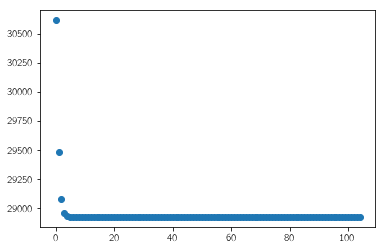

In [25]:
plt.scatter(np.arange(len(nll_after_rvs)), nll_after_rvs)
print(nll_after_rvs[0] - nll_after_rvs[-1])
# plt.yscale("log")

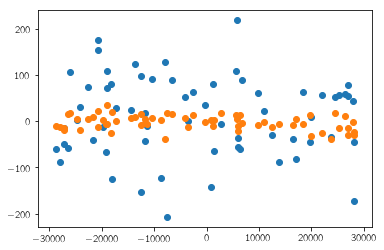

In [26]:
plt.scatter(true_rvs, starting_rvs - true_rvs)
plt.scatter(true_rvs, params_rvs - true_rvs)

In [27]:
np.std(params_rvs - true_rvs)

15.649074148147037

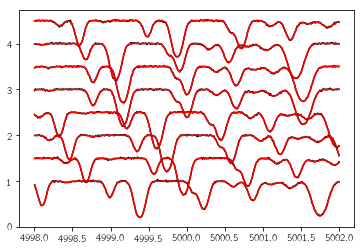

In [28]:
for n in range(8):
    offset = 0.5 * n
    plt.plot(data_xs[n], offset + data[n], color='k')
    plt.plot(data_xs[n], offset + np.exp(models_eval[n]), color='r')

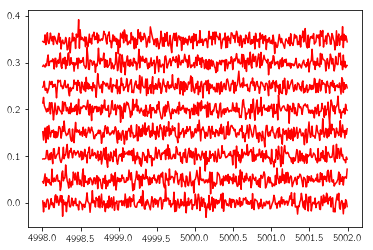

In [29]:
for n in range(8):
    offset = 0.05 * n
    plt.plot(data_xs[n], offset + data[n]- np.exp(models_eval[n]), color='r')